In [1]:
import pandas as pd
import os
# import seaborn as sns
import numpy as np
import re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
path = './' + 'data/'
os.listdir(path)
# os.cpu_count()

['OD集货量',
 '中转场历史到件量0301至0531.csv',
 '中转场历史到件量0601至0831.csv',
 '场地数据.csv',
 '班次数据0601至0831.csv',
 '运力配载数据0601至0831']

In [5]:
%%time
# trans = pd.read_json('./data/运力配载数据0601至0831/line_info_0601.json', lines=True)  # 36.2 sec
hist_arr = pd.read_csv(path + '中转场历史到件量0601至0831.csv')
loc = pd.read_csv(path + '场地数据.csv')
# # # loc.to_csv(path + '场地数据.csv', index = None, encoding='utf_8_sig')
task_arrange = pd.read_csv(path + '班次数据0601至0831.csv')


path_od = path + 'OD集货量/sep/'   
dfs = pd.DataFrame()
for fname in os.listdir(path_od):
    if re.search(r'\.csv$', fname):
        dfs = pd.concat(
            [dfs , pd.read_csv(path_od + fname)], axis = 0, ignore_index = True)
prc_in = pd.DataFrame(dfs) 
print(
    'loc:', loc.shape, '\nhist:' ,
    hist_arr.shape, '\ntask:',
    task_arrange.shape, '\nod:' ,
    dfs.shape)
del dfs

loc: (444, 22) 
hist: (61531, 6) 
task: (283832, 5) 
od: (68271366, 9)
Wall time: 4min 31s


### the story
以od为主表 通过时间和destination location join **history** 和 task ; location, 对task 和location中的缺失值进行处理.
location和task中的部分特征进行处理.
未来计划加入路线数据.

---

# Loc table clean  

In [2]:
# loc = pd.read_pickle('./data_clean/loc.p'); loc.shape

(444, 21)

In [168]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
loc[loc['场地代码'] == '552W']

,场地代码,场地类型,主服务业务区,单小时处理能力,卸货卡位总数,卸车卡位（17.5M）,卸车卡位（>=15M）,卸车卡位（<15M）,装货卡位总数,装车卡位（17.5M）,装车卡位（15M）,装车卡位（13.5M）,装车卡位（9.6M）,装车卡位（7.6M）,装车卡位（5.2M）,off,onn,off_p1,off_p2,onn_p1,onn_p2
205,552W,片区中转场,551Y,21516,12,False,True,True,87,False,True,True,False,False,False,22.77636,28.5,1.89803,0.261797,2.375,0.327586


In [6]:
# loc.columns
loc = loc.drop(['所在城市代码','应用场景', '分拨区' , '所在城市名称', '场地名称', '主服务城市','所在区部'], axis = 1) 
loc[[ '卸车卡位（17.5M）', '卸车卡位（>=15M）', '卸车卡位（<15M）', '装车卡位（17.5M）', '装车卡位（15M）',
       '装车卡位（13.5M）', '装车卡位（9.6M）', '装车卡位（7.6M）', '装车卡位（5.2M）']]  = loc[[ '卸车卡位（17.5M）', '卸车卡位（>=15M）', '卸车卡位（<15M）', '装车卡位（17.5M）', '装车卡位（15M）',
       '装车卡位（13.5M）', '装车卡位（9.6M）', '装车卡位（7.6M）', '装车卡位（5.2M）']] == 0
# loc[['装车卡位（13.5M）', '装车卡位（9.6M）', '装车卡位（7.6M）', '装车卡位（5.2M）']].describe()
# loc.head(2)
loc['off_1'] = loc['卸车卡位（17.5M）'] * 17.5
loc['off_2'] = loc['卸车卡位（>=15M）'] * 15
loc['off_3'] = loc['卸车卡位（<15M）'] * (13.5 * 0.970721 + 9.6 * 11.056306 + 7.6 * 2.279279 + 5.2 * 9.826577)/ \
    (0.970721 + 11.056306 + 2.279279 + 9.826577)
loc['onn_1'] = loc['装车卡位（17.5M）'] * 17.5
loc['onn_2'] = loc['装车卡位（15M）'] * 15
loc['onn_3'] = loc['装车卡位（13.5M）'] * 13.5
loc['onn_4'] = loc['装车卡位（9.6M）'] * 9.6
loc['onn_5'] = loc['装车卡位（7.6M）'] * 7.6
loc['onn_6'] = loc['装车卡位（5.2M）'] * 5.2
loc['off'] = loc['off_1'] + loc['off_2'] + loc['off_3']
loc['onn'] = loc['onn_1'] + loc['onn_2'] + loc['onn_3'] + loc['onn_4'] + loc['onn_5'] + loc['onn_6']
loc = loc.drop(['off_1','off_2', 'off_3', 'onn_1', 'onn_2', 'onn_3', 'onn_4', 'onn_5', 'onn_6'], axis = 1)

loc['off_p1'] = loc['off']/(loc['卸货卡位总数']+1)
loc['off_p2'] = loc['off']/(loc['装货卡位总数']+1)
loc['onn_p1'] = loc['onn']/(loc['卸货卡位总数']+1)
loc['onn_p2'] = loc['onn']/(loc['装货卡位总数']+1)




In [7]:
# loc.to_pickle('./data_clean/loc.p')
# corr_loc = loc.corr()
# corr_loc.style.background_gradient(cmap='coolwarm', axis=None)

# Task arrage clean

In [ ]:
# task_arrange[(task_arrange['operate_zone_code'] == '552W') & (task_arrange['batch_date'] == '2021-06-04')]

In [10]:
# pd.to_pickle(ta,  './data_clean/task.p')
# ta = pd.read_pickle('./data_clean/task.p')
# task_loc[task_loc['operate_zone_code'] == '010R']

In [8]:
%%time

ta = task_arrange.groupby(['operate_zone_code', 'batch_date']).\
    agg(min_begin = ('plan_begin_tm', min),
    max_begin = ('plan_begin_tm', max),
    min_end = ('plan_end_tm', min),
    max_end = ('plan_end_tm', max),
    count = ('batch_code', 'nunique')
    
    ).reset_index()

def convt_min(col):
    ta[col] = ta[col].apply(lambda i: datetime.strptime(i,'%H:%M').hour*60 + datetime.strptime(i,'%H:%M').minute)
     
for i in ['min_begin', 'max_begin', 'min_end','max_end']:
    convt_min(i)


# ta['time_consume_per_vote'] = (ta['max_end'] - ta['min_begin'])/ta['count']

Wall time: 1min 30s


In [67]:
corr_ta = ta.corr()
corr_ta.style.background_gradient(cmap='coolwarm', axis=None)


,min_begin,max_begin,min_end,max_end,count,time_consume_per_vote
min_begin,1.000000,0.082276,0.370383,-0.547887,-0.614004,-0.711813
max_begin,0.082276,1.000000,-0.547942,0.151572,0.506862,-0.416152
min_end,0.370383,-0.547942,1.000000,0.129046,-0.577872,0.298075
max_end,-0.547887,0.151572,0.129046,1.000000,0.564497,0.712461
count,-0.614004,0.506862,-0.577872,0.564497,1.000000,0.187662
time_consume_per_vote,-0.711813,-0.416152,0.298075,0.712461,0.187662,1.000000


In [31]:
# %%time
# import matplotlib.pyplot as plt
# ta_plt2 = pd.DataFrame(ta['operate_zone_code'].value_counts())
# ta_plt2 = pd.DataFrame(ta_plt2['operate_zone_code'].value_counts())
# ta_plt2['site'] = ta_plt2.index
# plt.pie(x = 'operate_zone_code' , data =ta_plt2)

In [68]:
# %%time
# task_loc = ta.merge(loc, left_on='operate_zone_code', right_on = '场地代码', how = 'left')

In [ ]:
%%time
del loc, ta 
# task_loc.to_pickle('./data_clean/task_loc.p')


In [51]:
# %%time
# task_loc_valued = task_loc[~task_loc['场地代码'].isna()]
# task_loc_nulled = task_loc[task_loc['场地代码'].isna()]

In [ ]:
# task_loc.isnull().sum()/len(task_loc)

---
# od

In [4]:
od = pd.read_pickle('./data_clean/od.p');od.head(5)
"""
历史到件量的场地不是每个都需要考虑的吧 集货OD对应的场地应该只有400出头 场地数据基本能覆盖的
"""

'\n只搞了10天的,   历史到件量的场地不是每个都需要考虑的吧 集货OD对应的场地应该只有400出头 场地数据基本能覆盖的\n'

In [ ]:
[prc_in[(prc_in['date1'] == '2021-06-08') & (prc_in['destsitecode'] == '552W')].sum(),
prc_in[(prc_in['date1'] == '2021-06-04') & (prc_in['srcsitecode'] == '552W')].sum()]

In [12]:
%%time
# prc_in.head()

od = prc_in.groupby(['srcsitecode','destsitecode', 'date1']).agg(
    batch_cnt = ('srcbatchcode', 'nunique'),
    route_cnt = ('route_code', 'nunique'),
    votes = ('votes', sum),
    weights = ('weight1', sum),
    air_votes =('air_votes', sum),
    air_weights = ('air_weight1', sum)
).reset_index()

od_dest = od.groupby(['destsitecode', 'date1']).agg(
    {'batch_cnt': sum, 
    'route_cnt': sum,
    'votes': sum, 
    'weights': sum,
    'air_votes': sum, 
    'air_weights':sum
    }).reset_index();od_dest

,destsitecode,date1,batch_cnt,route_cnt,votes,weights,air_votes,air_weights
0,010R,2021-06-01,9,11,16.0,140.800000,4.0,33.666667
1,010R,2021-06-02,7,8,8.0,34.600000,2.0,32.500000
2,010R,2021-06-03,8,10,17.0,106.216667,6.0,12.400000
3,010R,2021-06-04,4,7,28.0,194.175000,3.0,10.400000
4,010R,2021-06-05,5,6,7.0,15.333333,1.0,13.000000
...,...,...,...,...,...,...,...,...
40575,SIN01R,2021-08-27,259,162,4.0,63.214286,948.0,4761.035714
40576,SIN01R,2021-08-28,191,137,163.0,3361.500000,600.0,3263.191860
40577,SIN01R,2021-08-29,123,96,0.0,0.000000,279.0,1646.666667
40578,SIN01R,2021-08-30,261,160,14.0,189.500000,931.0,3824.500000


In [13]:
# od.to_pickle('./data_clean/od.p')

In [21]:
[od.date1.unique(), od.date1.max()]

[array(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
        '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08',
        '2021-06-09', '2021-06-10'], dtype=object),
 '2021-06-10']

---

# hist

In [42]:
hist_arr[(hist_arr['a.zonecode'] == '552W') & ( hist_arr['a.report_dt'] == '2021-06-04' )]

,a.report_dt,a.zonecode,all_arr_waybill,all_arr_weight,simu_arr_waybill,simu_arr_weight
35110,2021-06-04,552W,175334,472758.782153,6500,13488.254667


In [18]:
# hist_arr.to_pickle('./data_clean/hist_arr.p')
# merge all
# hist_arr = pd.read_pickle('./data_clean/hist_arr.p')
hist_arr.head()

--- 

# data subset to 10 days


In [14]:
# hist_arr_part = hist_arr[hist_arr['a.report_dt'] < '2021-06-11']

# od_dest = od.groupby(['destsitecode', 'date1']).agg(
#     {'batch_cnt': sum, 
#     'route_cnt': sum,
#     'votes': sum, 
#     'weights': sum,
#     'air_votes': sum, 
#     'air_weights':sum
#     }).reset_index();od_dest

--- 
# merge od_dest, ta, loc, hist_arr_part

In [20]:
[ta.columns,
od_dest.columns,
loc.columns,
hist_arr.columns]

[Index(['operate_zone_code', 'batch_date', 'min_begin', 'max_begin', 'min_end',
        'max_end', 'count'],
       dtype='object'),
 Index(['destsitecode', 'date1', 'batch_cnt', 'route_cnt', 'votes', 'weights',
        'air_votes', 'air_weights'],
       dtype='object'),
 Index(['场地代码', '场地类型', '主服务业务区', '单小时处理能力', '卸货卡位总数', '卸车卡位（17.5M）',
        '卸车卡位（>=15M）', '卸车卡位（<15M）', '装货卡位总数', '装车卡位（17.5M）', '装车卡位（15M）',
        '装车卡位（13.5M）', '装车卡位（9.6M）', '装车卡位（7.6M）', '装车卡位（5.2M）', 'off', 'onn',
        'off_p1', 'off_p2', 'onn_p1', 'onn_p2'],
       dtype='object'),
 Index(['a.report_dt', 'a.zonecode', 'all_arr_waybill', 'all_arr_weight',
        'simu_arr_waybill', 'simu_arr_weight'],
       dtype='object')]

In [22]:
od_dest.merge(ta, \
    left_on=['destsitecode', 'date1'], 
    right_on = ['operate_zone_code', 'batch_date'],
    how = 'left',  validate = 'one_to_one')  .isna().sum()

destsitecode           0
date1                  0
batch_cnt              0
route_cnt              0
votes                  0
weights                0
air_votes              0
air_weights            0
operate_zone_code    267
batch_date           267
min_begin            267
max_begin            267
min_end              267
max_end              267
count                267
dtype: int64

In [74]:
"""
od_dest , ta, loc, hist_arr_part
"""
od_ta = od_dest.merge(ta, \
    left_on=['destsitecode', 'date1'], 
    right_on = ['operate_zone_code', 'batch_date'],
    how = 'left',  validate = 'one_to_one') 
    # task arrange lakc 267


od_ta_his = hist_arr.merge(
    od_ta, 
    left_on = ['a.report_dt', 'a.zonecode'], 
    right_on = ['date1', 'destsitecode'], validate = 'one_to_one', how = 'right') \
        # .isna().sum()   264



od_ta_his_loc = od_ta_his.merge(loc, \
    left_on=['destsitecode' ], 
    right_on = ['场地代码'],
    how = 'left')
    #  .isna().sum() 1388

In [75]:
od_ta_his_loc = od_ta_his_loc.drop(['a.report_dt', 'a.zonecode','operate_zone_code','batch_date', \
    '场地代码','场地类型' ,'主服务业务区'], axis= 1)

In [26]:
# od_ta_his = od_ta_his.drop(['a.report_dt', 'a.zonecode','operate_zone_code','batch_date'], axis= 1)

In [76]:
od_ta_his_loc.isna().sum() 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
imp = SimpleImputer('median', missing_values = np.nan )
imp2 = KNNImputer(n_neighbors=12, weights="uniform", missing_values = np.nan)
# imp.fit_transform(od_ta_his[list(impute.index)])

C:\Users\dscshap3808\Miniconda3\envs\siming\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass missing_values=median as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [77]:
impute = pd.DataFrame(od_ta_his_loc.isna().sum() != 0)
impute = impute[impute[0] == True] 


for i in impute.index:
    od_ta_his_loc[i] = od_ta_his_loc[i].astype(float)

# # del loc, hist_arr  
 

In [73]:
# od_ta_his_loc = od_ta_his_loc[['all_arr_waybill', 'all_arr_weight', 'simu_arr_waybill',
#        'simu_arr_weight', 'destsitecode', 'date1', 'batch_cnt', 'route_cnt',
#        'votes', 'weights', 'air_votes', 'air_weights']]

In [82]:
od_ta_his_loc[impute.index.to_list()].isna().sum() 

all_arr_waybill      1983
all_arr_weight       1983
simu_arr_waybill     1983
simu_arr_weight      1983
min_begin             267
max_begin             267
min_end               267
max_end               267
count                 267
单小时处理能力             10572
卸货卡位总数              10572
卸车卡位（17.5M）         10572
卸车卡位（>=15M）         10572
卸车卡位（<15M）          10572
装货卡位总数              10572
装车卡位（17.5M）         10572
装车卡位（15M）           10572
装车卡位（13.5M）         10572
装车卡位（9.6M）          10572
装车卡位（7.6M）          10572
装车卡位（5.2M）          10572
off                 10572
onn                 10572
off_p1              10572
off_p2              10572
onn_p1              10572
onn_p2              10572
dtype: int64

In [1]:
%%time
"""
knn imputation on missing values.
label encoding.
standard scale.
"""
# od_ta_his_loc[impute.index.to_list()] = imp2.fit_transform(od_ta_his_loc[impute.index.to_list()])
# pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

Wall time: 0 ns


'\nknn imputation on missing values.\nlabel encoding.\nstandard scale.\n'

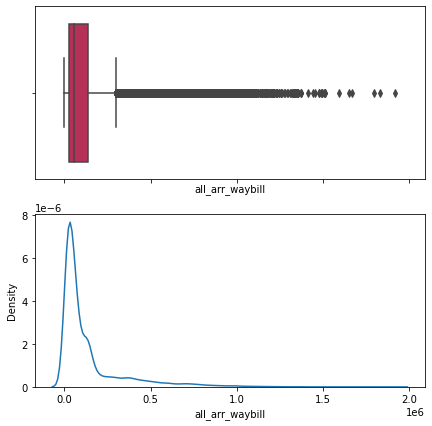

In [64]:
sns.color_palette("rocket", as_cmap=True)
def plot_distribution(col):
    f, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    sns.boxplot(x = col,data = od_ta_his_loc, ax=axes[0], palette = "rocket")
    sns.kdeplot(x = col,data = od_ta_his_loc, ax=axes[1], palette = "rocket") 

plot_distribution('all_arr_waybill')

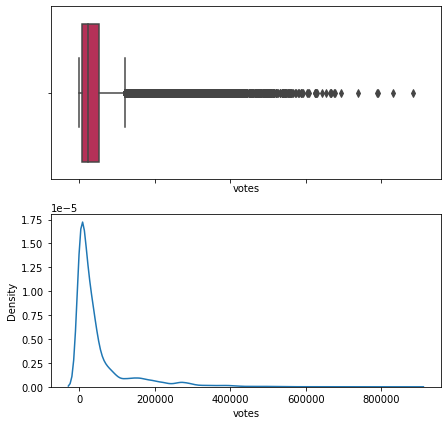

In [65]:
plot_distribution('votes')

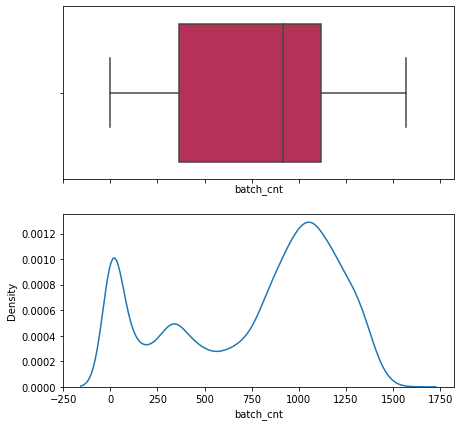

In [66]:
plot_distribution('batch_cnt')

# lag features


In [ ]:
def lag_feature( df, lags, cols):
    for col in cols:
        print(col)
        tmp = df[['destsitecode',col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ['destsitecode', col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['destsitecode'], how='left')
    return df

In [87]:
# hist_od_part = hist_arr_part.merge(
#     od_dest, 
#     left_on = ['a.report_dt', 'a.zonecode'], 
#     right_on = ['date1', 'destsitecode'], validate = 'one_to_one', how = 'right'); len(hist_od_part)

# hist_od_part = hist_od_part.drop(['a.report_dt','a.zonecode'], axis =1 )

In [53]:
# del od, task_loc, hist_arr
# del task_loc_nulled, task_loc_valued
# # [len(task_loc), len(train), len(od)]

---
# transport


In [206]:
trans.iloc[11:12,:]

,cvyName,cvyType,lineCode,lineKey,lineRequireDate,passZoneCodes,stopOver,taskInfos,transportLevel,vehicleInfos
11,北方枣庄0600（常规）,4,536XA632VA0600,"536XA632VA0600_2021-06-03_536XA,632VA",2021-06-03,"[{'arriveBatchCode': '632VA1200', 'arriveTm': ...",False,[{'drivingFactors': 'T6|632VA;T77|632VA;T4|632...,2,"[{'extraMinLoadWeight': 3900000.1549720764, 'l..."


In [194]:
trans.iloc[11,:]['passZoneCodes'][0]

{'arriveBatchCode': '632VA1200',
 'arriveTm': 1622693460000,
 'destZoneCode': '632VA',
 'order': 1,
 'sendBatchCode': '536XA2359',
 'sendTm': 1622671200000,
 'sendZoneCode': '536XA'}

In [242]:
trans.iloc[11,:]['taskInfos'][0] # ['unloadZone']

{'drivingFactors': 'T6|632VA;T77|632VA;T4|632VA;T1;T8;T29|632VA;ZT4|632VA;ZT6|632VA',
 'loadZone': '536XA',
 'taskId': '536XA_632VA',
 'unloadZone': '632VA'}

In [227]:
%%time
# set(re.findall('\|\w+', trans.iloc[11,:]['taskInfos'][0]['drivingFactors']))
taskInfos = pd.DataFrame.from_dict(trans['taskInfos'][0:5])['taskInfos'].apply(pd.Series)

Wall time: 10 ms


In [243]:
test = trans.iloc[0:5,]

In [ ]:
%%time
# set(re.findall('\|\w+', trans.iloc[11,:]['taskInfos'][0]['drivingFactors']))
taskInfos = pd.DataFrame.from_dict(trans['taskInfos'][0:5])['taskInfos'].apply(pd.Series)

In [ ]:
test = trans.iloc[0:5,]

In [ ]:
from pandas.io.json import json_normalize #package for flattening json i


In [ ]:
trans.iloc[1,:]['vehicleInfos'][0] # ['unloadZone']

In [ ]:
test['vehicleInfos'][0]

In [ ]:
pd.json_normalize(test['vehicleInfos'], 'vehicleType', '')

---
# what a model

In [ ]:
od_ta_his_loc.columns

Index(['all_arr_waybill', 'all_arr_weight', 'simu_arr_waybill',
       'simu_arr_weight', 'destsitecode', 'date1', 'batch_cnt', 'route_cnt',
       'votes', 'weights', 'air_votes', 'air_weights'],
      dtype='object')

In [69]:

train_data = od_ta_his_loc[od_ta_his_loc['destsitecode'] == '010W'] 
train_x = train_data.drop(['all_arr_weight', 'simu_arr_waybill','simu_arr_weight',\
    'destsitecode'], axis = 1)
train_x = train_x[['all_arr_waybill', 'date1', 'batch_cnt', 'route_cnt',
       'votes', 'weights', 'air_votes', 'air_weights']]

In [70]:
train_x.index = pd.to_datetime(train_x['date1'])
train_x = train_x.asfreq('D')
train_x = train_x.rename({'all_arr_waybill' : 'y' }, axis = 1)

cols = [i for i in train_x.columns if i not in ['y', 'date1']]

In [71]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import mean_absolute_percentage_error
x_train, x_test = temporal_train_test_split(train_x, train_size = .7)

In [72]:
%%time

from fbprophet import Prophet
# df = x[['CREATION_DATE_TIME_STAMP', 'qty']]
df_naiv = x_train 
df_naiv = df_naiv.rename({'date1' : 'ds'}, axis = 1)
m = Prophet()
[m.add_regressor(i) for i in cols]

m.fit(df_naiv)

from sklearn.metrics import mean_absolute_percentage_error
df_naiv_test = x_test
df_naiv_test = df_naiv_test.rename({'date1' : 'ds'}, axis = 1)
# m.predict(x_test)
mean_absolute_percentage_error(df_naiv_test['y'], m.predict(df_naiv_test)['yhat'])
# ss

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 13.5 s


0.13727093037314864

In [137]:
# m.plot_components(m.predict(df_naiv))

In [127]:
# %%warning = False
import plotly.express as px
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

# test_pre_p = go.Figure()
# test_pre_p.add_trace(go.Scatter(x = test_pred['ds'],\
#     y = test_pred['yhat'], 
#     mode = 'markers',
#     name = 'pred'))
# test_pre_p.add_trace(go.Scatter(x = test_all['ds'], \
#     y = test_all['y'], 
#     mode = 'markers',
#     name = 'original_out'))


'c:\\Users\\dscshap3808\\Documents\\my_scripts_new\\play7_comp'

In [144]:
# !jupyter nbconvert data_clea.ipynb --to html --no-input --no-prompt --stdout

In [145]:

# select 
# case when warehouse = 'HPI_SH'
# and work_zone = 'Caolu'
# then 'HPPXXSMFS' 
# when warehouse = 'HPI_WH'
# then 'HPPXXWHWDS' 
# else 'HPPXXSHMGS' end
# as ou_code , warehouse, work_zone
# from 
# (
# select warehouse, work_zone from ods_cn_hpi.location
# group by warehouse, work_zone
# )
    
# """
# hp mapping
# """

